In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Stat data

In [2]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [3]:
stat_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:-1]]

In [4]:
for yi in range(len(stat_list)):
    y = files[yi].split('.')[0]
    c = stat_list[yi].columns
    c = [y+'-'+ci for ci in c]
    # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
    stat_list[yi].columns = c

## Poll data

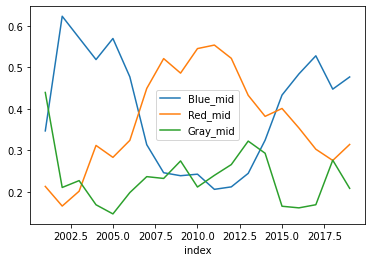

In [5]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_edited_middle_year_of_voting.csv', index_col=0)
pool_data_middle.plot()
plt.show()

## Voting data

In [6]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [7]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [8]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [9]:
vote_list[0] = vote_list[0].set_index('województwo')

In [10]:
if(False):
    for yi in range(len(vote_list)):
        y = files[yi].split('_WS')[0]
        c = vote_list[yi].columns
        #c = [y+'-'+ci for ci in c]
        # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
        vote_list[yi].columns = c

        #vote_list[yi] = vote_list[yi].div(vote_list[yi].sum(axis=1), axis=0).fillna(0)

## Neighbours

In [11]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [12]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
                
    par_in_reg_list.append(party_in_region(df_vote, pool[1]))
    reg_in_par_list.append(region_in_party(df_vote, pool[1]))

In [13]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl
    reg_in_par_list[i] = vl

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [14]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(pool_data_middle.shape[0]-1):
    # iterate over districts
    tmp_x = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = par_in_reg_list[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [par_in_reg_list[y].loc[n.upper()][0]/par_in_reg_list[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        tmp_x.append([lo[0]/lo.sum(), avg_n, 1])
    X.append(tmp_x)

In [15]:
X = np.array(X)
X.shape

(18, 16, 3)

## Prepare Y

In [16]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = par_in_reg_list[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [17]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [135]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights
    x - vector of input data 
    OUTPUT:
    y - predicted value in (0,1)
    '''
    #return 1 / (1+np.exp(-np.sum(x*a,1,keepdims=True)))
    x = x.reshape(-1,3)
    return 1 / (1+np.exp(-np.sum(x.dot(a.T))))

def model_value(a,x):
    '''
    INPUT:
    a - vector of weights
    x - vector of input data
    OUTPUT:
    y - predicted value {-1, 1}
    '''
    return np.sign(x.T.dot(a))

def grad_percent(a,x):
    '''
    INPUT:
    a - vector of weights 18*16 x 3
    x - vector of input data 18x16x3
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    x = x.reshape(-1,3)
    return a*np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) / (1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2

def grad_value(a,x):
    val = x.dot(a)
    if val > 0: out = 1
    elif val < 0: out = -1
    else: out= 0
        
    return out

In [142]:
loss_p = np.inf
loss_v = np.inf

ap = np.random.rand(X.shape[1],X.shape[2])
av = np.random.rand(X.shape[1],X.shape[2])

step = 0.1
beta = 0.01
ap.shape

(16, 3)

In [143]:
for epoch in range(10**3):
    ap_long = np.repeat(ap,18,axis=0)
    grad = grad_percent(ap_long,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    ap = ap - step*grad
    
    ap_long = np.repeat(ap,18,axis=0)
    if epoch%50==0: 
        if np.sum((model_percent(ap_long,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
        else: step /= (1-beta)

    loss_p = np.sum((model_percent(ap_long,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print(loss_p, np.max(grad), grad.shape)
ap.shape

93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)
93.50505554651397 2.5675309454731577e-81 (16, 3)


(16, 3)

In [144]:
if(False):
    for epoch in range(10**(3)):
        for y in range(X.shape[0]):
            ap = ap - step*grad_percent(ap,X[y])

            if epoch%50==0 and y==0 and False: 
                if np.sum((model_percent(ap,X[y]) - Y[y])**2) < loss_p: step *= (1+beta)
                else: step /= (1-beta)

            loss_p = np.sum((model_percent(ap,X[y]) - Y[y])**2)

            if epoch%100==0 and y==0: 
                print(loss_p)
    ap.shape

In [145]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [146]:
def prepare_input(y):
    tmp_x = np.zeros((y.shape[0],3))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        tmp_x[d] = np.array([y[d,0], avg_n, 1])
    return(tmp_x)

In [149]:
def model(a,x,Y):
    y = Y[0]
    loss = 0
    for year in range(1,X.shape[0]):
        xi = prepare_input(y)
        y = model_percent(a,xi)
        loss += np.sum((y - Y[year])**2)
        print(y.shape,'loss:', np.sum((y - Y[year])**2))
        print(np.round(Y[year].T,2))
        print(np.round(y.T,2))
        return loss

In [150]:
model(ap,X,Y)

() loss: 0.6219424417795363
[[0.78 0.84 0.91 0.79 0.83 0.8  0.69 0.86 0.89 0.72 0.83 0.81 0.8  0.86
  0.71 0.89]]
1.0


0.6219424417795363

In [41]:
ap

array([[2.08140017e-222, 2.92715077e-222, 2.26706012e-221],
       [2.76749647e-221, 2.32175768e-221, 1.00189040e-221],
       [9.60659449e-222, 1.15291220e-221, 1.32034849e-221],
       [1.86546673e-221, 1.17504592e-221, 1.85881599e-222],
       [2.04344386e-221, 7.46636709e-222, 4.76930343e-222],
       [9.99828046e-223, 4.74432751e-222, 2.17030816e-221],
       [6.77053737e-222, 2.98653358e-221, 2.37326164e-221],
       [5.88663628e-223, 3.99156280e-222, 2.79884639e-223],
       [1.77255497e-221, 1.25409465e-221, 2.07597667e-222],
       [2.50935605e-221, 1.35463457e-221, 1.50038202e-221],
       [4.09985548e-222, 1.72700538e-221, 7.45352031e-222],
       [5.32094351e-222, 9.03941710e-222, 2.26638501e-221],
       [8.71354506e-222, 1.77600539e-221, 1.10097928e-221],
       [2.62728604e-221, 9.01838341e-222, 1.70338717e-221],
       [4.50258627e-222, 1.56767426e-221, 1.93226089e-224],
       [1.58017530e-221, 2.62588054e-223, 7.98409186e-222]])

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI